# Investment Analysis Assignment

# Checkpoint 1: Data Cleaning 1
Code for results of Table 1.1 : Understand the Data Set 

In [1]:
#Importing Libraries
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
companies = pd.read_csv('companies.txt',sep='\t',encoding = "ISO-8859-1")
rounds2 = pd.read_csv('rounds2.csv',encoding = "ISO-8859-1")

In [3]:
#unique companies present in rounds2
print(rounds2.company_permalink.nunique())

90247


In [4]:
#unique companies are present in companies
print(companies.permalink.nunique())

66368


Cleaning both Datafrane and then Merging rounds2 & companies dataframe, eventually obtaining master_frame 

In [5]:
#Befor merging rename the joining column to common name and also conver both the joining column to lower case to avoid mismatches
companies.rename(columns={'permalink':'company_permalink'}, inplace=True)
companies['company_permalink'] = companies['company_permalink'].str.lower()
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()

#Performing Inner join of rounds2 with companies as doing left join wouldn't make much sense as columns for our analysis purpose are dependent on companies dataframe.


In [6]:
#Merge to obtain Master Frame
master_frame = pd.merge(rounds2,companies,on = 'company_permalink' ,how = 'inner')

In [7]:
#creating a master frame copy from checkpoint 1 to be used in plotting
master_frame_copy = pd.merge(rounds2,companies,on = 'company_permalink' ,how = 'inner')

In [8]:
#To find number of observation
len(master_frame)

114942

# Checkpoint 2: Funding Type Analysis

In [9]:
#Data Cleaning for funding type analysis

In [10]:
#identify number of non null values in each column and decide whether this affects analysis, if so then impute or drop NaN values
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114942 entries, 0 to 114941
Data columns (total 15 columns):
company_permalink          114942 non-null object
funding_round_permalink    114942 non-null object
funding_round_type         114942 non-null object
funding_round_code         31139 non-null object
funded_at                  114942 non-null object
raised_amount_usd          94958 non-null float64
name                       114941 non-null object
homepage_url               108810 non-null object
category_list              111535 non-null object
status                     114942 non-null object
country_code               106271 non-null object
state_code                 104003 non-null object
region                     104782 non-null object
city                       104785 non-null object
founded_at                 94422 non-null object
dtypes: float64(1), object(14)
memory usage: 14.0+ MB


#Based on above information , Dropping Nan Values seems to be fair as it cant be imputed by replacing with avarage as there are multiple factors like country , funding type etc.

In [11]:
# Drop NaN Values from raised_amount_usd
master_frame = master_frame.dropna(subset = ['raised_amount_usd'])


In [12]:
#Checking results after dropping
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94958 entries, 0 to 114941
Data columns (total 15 columns):
company_permalink          94958 non-null object
funding_round_permalink    94958 non-null object
funding_round_type         94958 non-null object
funding_round_code         28169 non-null object
funded_at                  94958 non-null object
raised_amount_usd          94958 non-null float64
name                       94957 non-null object
homepage_url               90626 non-null object
category_list              93914 non-null object
status                     94958 non-null object
country_code               89108 non-null object
state_code                 87355 non-null object
region                     87911 non-null object
city                       87914 non-null object
founded_at                 78992 non-null object
dtypes: float64(1), object(14)
memory usage: 11.6+ MB


In [13]:
# Filtering four types of investment 
master_frame = master_frame[master_frame['funding_round_type'].isin(['venture','seed','angel','private_equity'])]


In [14]:
#creating a copy of master frame to be used in plotting
master_frame_copy  = master_frame_copy[master_frame_copy['funding_round_type'].isin(['venture','seed','angel','private_equity'])]

In [15]:
#Claculating Average funding amount for each funding type
pd.set_option('display.float_format', lambda x: '%.3f' % x)
master_frame.groupby('funding_round_type').mean()[['raised_amount_usd']]

,raised_amount_usd
funding_round_type,
angel,958694.470
private_equity,73308593.029
seed,719779.620
venture,11748949.129


#Most representative value of the investment amount
As per fundamentals of statistics , most representative value can be found out by calculating mode 

In [16]:
#finding Most Representative Value and we need to pick funding type only funding amount between 5 to 15 million USD
master_frame.groupby('funding_round_type')[['raised_amount_usd']].agg(lambda x: stats.mode(x['raised_amount_usd'])[0])
#By observing the results, we'd like to invest in venture funding type

,raised_amount_usd
funding_round_type,
angel,500000.000
private_equity,100000000.000
seed,1000000.000
venture,10000000.000


# Checkpoint 3: Country Analysis

Finding the top nine countries which have received the highest total funding (across ALL sectors for the chosen investment type)

In [17]:
#Filtering out venture funding type
master_frame = master_frame[master_frame['funding_round_type'] == 'venture']

In [18]:
#Create a list of English speaking country codes for filtering purposes
eng_cd = ['USA','GBR','IND','CAN','FRA','CHE','SGP','IRL','AUS']

In [19]:
#Aggregating Funding amount countrywise
grouped_country = master_frame[['country_code','raised_amount_usd']].groupby('country_code').sum()[['raised_amount_usd']]
grouped_country.reset_index(inplace=True)

In [20]:
top9 = grouped_country[grouped_country.country_code.isin(eng_cd)].nlargest(30,'raised_amount_usd')
print(top9[['country_code','raised_amount_usd']])

   country_code  raised_amount_usd
94          USA   422510842796.000
29          GBR    20245627416.000
39          IND    14391858718.000
12          CAN     9583332317.000
28          FRA     7259536732.000
13          CHE     2827560264.000
81          SGP     2793917856.000
40          IRL     1676131350.000
3           AUS     1322934948.000


# Plotting

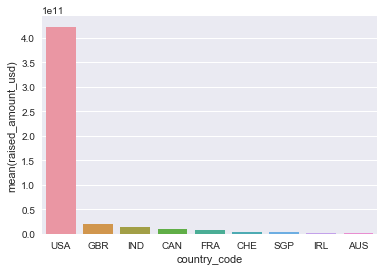

In [21]:
import seaborn as sns
%matplotlib inline
top9.reset_index(inplace=True)
sns.barplot(x='country_code', y='raised_amount_usd', data=top9)


# #Checkpoint 4: Sector Analysis 1

##Extract the primary sector of each category list from the category_list column

In [22]:
#Filtering top 3 english speaking countries
master_frame = master_frame[master_frame['country_code'].isin(['IND','USA','GBR'])]

In [23]:
#extracting primary_sector based on business rules
master_frame['primary_sector'] = master_frame['category_list'].str.split("|",n=1,expand = True).loc[:,0]

#Before megring with mapping file we need to do some basic data cleaning


In [24]:
# After basic analysis we see that category list values needs Replacing '0' with 'na' , will use Regex and drop Blaks column
mapping_df = pd.read_csv('mapping.csv',encoding = "ISO-8859-1")
mapping_df = mapping_df.drop(['Blanks'],axis =1)
mapping_df['category_list'] = mapping_df['category_list'].replace(['0'],['na'],regex=True)

In [25]:
# Also remove Nan Values form Category_list Column
mapping = mapping_df.dropna(subset = ['category_list'])

In [26]:
import warnings
warnings.filterwarnings("ignore")
#before merging convert joining column to lower case
master_frame['primary_sector'] = master_frame['primary_sector'].str.lower()
mapping['category_list'] = mapping['category_list'].str.lower()

In [27]:
#coding for merged dataframe 
merged_df = pd.merge(master_frame,mapping, left_on='primary_sector',right_on ='category_list',how ='inner')

In [28]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38788 entries, 0 to 38787
Data columns (total 25 columns):
company_permalink                          38788 non-null object
funding_round_permalink                    38788 non-null object
funding_round_type                         38788 non-null object
funding_round_code                         21079 non-null object
funded_at                                  38788 non-null object
raised_amount_usd                          38788 non-null float64
name                                       38788 non-null object
homepage_url                               36998 non-null object
category_list_x                            38788 non-null object
status                                     38788 non-null object
country_code                               38788 non-null object
state_code                                 38716 non-null object
region                                     38632 non-null object
city                                       38

In [29]:
#create another column called main_sector based on information from mappings file
cols = merged_df.loc[:,'Automotive & Sports':'Social, Finance, Analytics, Advertising'].columns
merged_row_traverse = merged_df.loc[:,'Automotive & Sports':'Social, Finance, Analytics, Advertising']
bt = merged_row_traverse.apply(lambda x: x > 0)
merged_df['main_sector'] = bt.apply(lambda x: list(cols[x.values]), axis=1)

In [30]:
#converting list values in main_sector to string
merged_df['main_sector'] = merged_df['main_sector'].agg(lambda x: ','.join(map(str, x)))

# Checkpoint 5: Sector Analysis 2


Computig D1 D2 and D3 dataframes as per requirement

In [31]:
#D1 (USA)
D1 = merged_df[(merged_df['country_code'] =='USA') & (merged_df['raised_amount_usd'] >= 5000000) & (merged_df['raised_amount_usd'] <= 15000000)]
d1_agg = D1[['raised_amount_usd','main_sector']].groupby(['main_sector']).agg(['count','sum'])
D1 = D1.join(d1_agg,on='main_sector')
D1.columns.values[-1] = 'investment_sum'
D1.columns.values[-2] = 'investment_count'

In [32]:
#D2 (GBR)
D2 = merged_df[(merged_df['country_code'] =='GBR') & (merged_df['raised_amount_usd'] >= 5000000) & (merged_df['raised_amount_usd'] <= 15000000)]
d2_agg = D2[['raised_amount_usd','main_sector']].groupby(['main_sector']).agg(['count','sum'])
D2 = D2.join(d2_agg,on='main_sector')
D2.columns.values[-1] = 'investment_sum'
D2.columns.values[-2] = 'investment_count'

In [33]:
#D3 (IND)
D3 = merged_df[(merged_df['country_code'] =='IND') & (merged_df['raised_amount_usd'] >= 5000000) & (merged_df['raised_amount_usd'] <= 15000000)]
d3_agg = D3[['raised_amount_usd','main_sector']].groupby(['main_sector']).agg(['count','sum'])
D3 = D3.join(d3_agg,on='main_sector')
D3.columns.values[-1] = 'investment_sum'
D3.columns.values[-2] = 'investment_count'

In [34]:
# by looking at the aggregated datafarme for country 1 we can find answers for table 5.1
#Coutry 1
d1_agg


raised_amount_usd                
                                                    count             sum
main_sector                                                              
Automotive & Sports                                   167  1454104361.000
Cleantech / Semiconductors                           2350 21633430822.000
Entertainment                                         591  5099197982.000
Health                                                909  8211859357.000
Manufacturing                                         799  7258553378.000
News, Search and Messaging                           1583 13971567428.000
Others                                               2950 26321007002.000
Social, Finance, Analytics, Advertising              2714 23807376964.000

In [35]:
#Coutry 2
d2_agg

raised_amount_usd               
                                                    count            sum
main_sector                                                             
Automotive & Sports                                    16  167051565.000
Cleantech / Semiconductors                            130 1163990056.000
Entertainment                                          56  482784687.000
Health                                                 24  214537510.000
Manufacturing                                          42  361940335.000
News, Search and Messaging                             73  615746235.000
Others                                                147 1283624289.000
Social, Finance, Analytics, Advertising               133 1089404014.000

In [36]:
#country 3
d3_agg

raised_amount_usd               
                                                    count            sum
main_sector                                                             
Automotive & Sports                                    13  136900000.000
Cleantech / Semiconductors                             20  165380000.000
Entertainment                                          33  280830000.000
Health                                                 19  167740000.000
Manufacturing                                          21  200900000.000
News, Search and Messaging                             52  433834545.000
Others                                                110 1013409507.000
Social, Finance, Analytics, Advertising                60  550549550.000

In [37]:
#Highest Investment for Country1
D1_main_sector = D1[D1['main_sector']=='Others']
D1_main_sector[['name','main_sector']].groupby(['name']).agg(['count']).sort_values(by=('main_sector','count'),ascending=False).head(5)


,main_sector
,count
name,
Capella Photonics,6
Black Duck Software,6
Virtustream,6
Integrien,5
Delivery Agent,5


In [38]:
#2nd Best Investment for Country1
D1_main_sector_2nd = D1[D1['main_sector']=='Social, Finance, Analytics, Advertising']
D1_main_sector_2nd[['name','main_sector']].groupby(['name']).agg(['count']).sort_values(by=('main_sector','count'),ascending=False).head(5)


,main_sector
,count
name,
NetBase Solutions,7
SST Inc. (Formerly ShotSpotter),7
YuMe,6
OpTier,6
FirstRain,6


In [39]:
#Highest Investment for Country2
D2_main_sector = D2[D2['main_sector']=='Others']
D2_main_sector[['name','main_sector']].groupby(['name']).agg(['count']).sort_values(by=('main_sector','count'),ascending=False).head(5)

,main_sector
,count
name,
SenSage,4
Electric Cloud,4
OpenCloud,3
SilverRail Technologies,3
Enigmatec,3


In [40]:
#2nd Best Investment for Country2
D2_main_sector_2nd = D2[D2['main_sector']=='Social, Finance, Analytics, Advertising']
D2_main_sector_2nd[['name','main_sector']].groupby(['name']).agg(['count']).sort_values(by=('main_sector','count'),ascending=False).head(5)


,main_sector
,count
name,
myThings,4
Celltick Technologies,4
VisualDNA,3
Garlik,3
Amplience,3


In [41]:
#Highest Investment for Country2
D3_main_sector = D3[D3['main_sector']=='Others']
D3_main_sector[['name','main_sector']].groupby(['name']).agg(['count']).sort_values(by=('main_sector','count'),ascending=False).head(5)


,main_sector
,count
name,
Myntra,4
FirstCry.com,3
Pepperfry.com,3
CommonFloor,3
Comat Technologies,2


In [42]:
# 2nd Best Investment for Country2
D3_main_sector_2nd = D3[D3['main_sector']=='Social, Finance, Analytics, Advertising']
D3_main_sector_2nd[['name','main_sector']].groupby(['name']).agg(['count']).sort_values(by=('main_sector','count'),ascending=False).head(5)


,main_sector
,count
name,
Manthan Systems,4
Komli Media,3
Qyuki,2
inTarvo,2
Microland,2


# Checkpoint 6: Plots

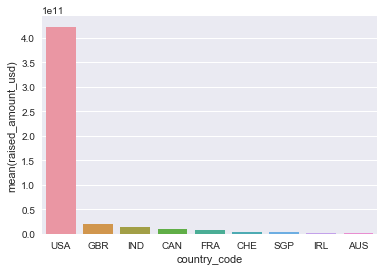

In [43]:
import seaborn as sns
%matplotlib inline
top9.reset_index(inplace=True)
sns.barplot(x='country_code', y='raised_amount_usd', data=top9)

#plot showing total investments (globally) in venture, seed, and private equity, and the average amount of investment in each funding type


In [44]:
# creating a temo Dataframe for storing variable

temp1 = master_frame_copy.groupby('funding_round_type').size().reset_index(name='counts')
temp1['total'] = temp1.counts.sum()
temp1['Percentage'] = 100 * temp1['counts']  / temp1['total']
temp1

,funding_round_type,counts,total,Percentage
0,angel,6094,94390,6.456
1,private_equity,2285,94390,2.421
2,seed,30518,94390,32.332
3,venture,55493,94390,58.791


In [45]:
#calculating mean and storing in a dataframe
result2 = pd.DataFrame(master_frame_copy.groupby('funding_round_type')['raised_amount_usd'].agg('mean'))
result2.reset_index()

,funding_round_type,raised_amount_usd
0,angel,958694.470
1,private_equity,73308593.029
2,seed,719779.620
3,venture,11748949.129


In [46]:
# joining both the dfs to obtain temp df for plotting
temp1 = temp1.join(result2,on='funding_round_type')
temp1

,funding_round_type,counts,total,Percentage,raised_amount_usd
0,angel,6094,94390,6.456,958694.470
1,private_equity,2285,94390,2.421,73308593.029
2,seed,30518,94390,32.332,719779.620
3,venture,55493,94390,58.791,11748949.129


In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


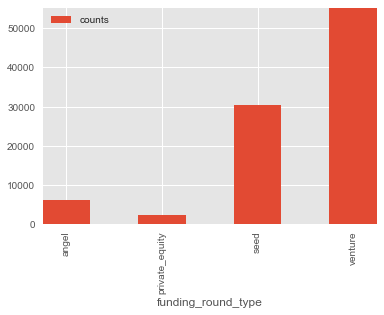

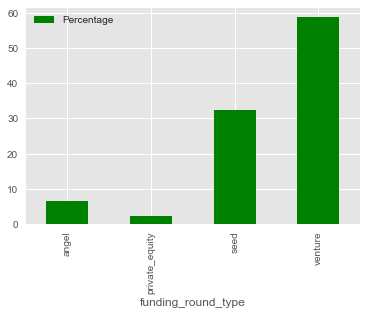

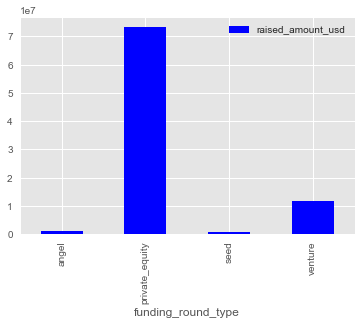

In [48]:
# gca stands for 'get current axis'
ax = plt.gca()

temp1.plot(kind='bar',x='funding_round_type',width=0.5,y='counts',ax=ax ,align = 'center')
temp1.plot(kind='bar',x='funding_round_type',width=0.5,y='Percentage', color='green',align = 'center')
temp1.plot(kind='bar',x='funding_round_type',width=0.5,y='raised_amount_usd', color='blue',align = 'center')
ax.autoscale(tight=True)

plt.show()

Creating Temp dataframes for top three countries with filters on top3 sectors. We have already created dataframes for top3 country we can use that as refernce.

Axes(0.125,0.125;0.775x0.755)


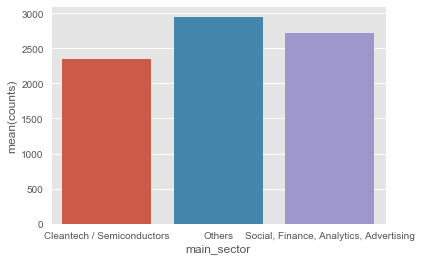

In [49]:
# First create a list  to store top3 sectors for D1 : Country1
top3_sectors_D1 = ['Others','Social, Finance, Analytics, Advertising','Cleantech / Semiconductors']
temp_d1 = D1[D1['main_sector'].isin(top3_sectors_D1)].groupby('main_sector').size().reset_index(name='counts')
#Plot for country1
print(sns.barplot(x='main_sector', y='counts', data=temp_d1))

Axes(0.125,0.125;0.775x0.755)


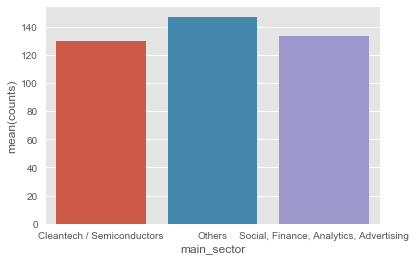

In [50]:
# First create a list  to store top3 sectors for D2 : Country2
top3_sectors_D2 = ['Others','Social, Finance, Analytics, Advertising','Cleantech / Semiconductors']
temp_d2 = D2[D2['main_sector'].isin(top3_sectors_D2)].groupby('main_sector').size().reset_index(name='counts')
#Plot for country 3
print(sns.barplot(x='main_sector', y='counts', data=temp_d2))

Axes(0.125,0.125;0.775x0.755)


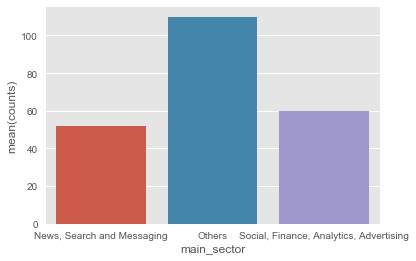

In [51]:
# First create a list  to store top3 sectors for D3 : Country3
top3_sectors_D3 = ['Others','Social, Finance, Analytics, Advertising','News, Search and Messaging']
temp_d3 = D3[D3['main_sector'].isin(top3_sectors_D3)].groupby('main_sector').size().reset_index(name='counts')
#Plot for country 3
print(sns.barplot(x='main_sector', y='counts', data=temp_d3))
